# Data Science Pipeline

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib.ticker as ticker
from datetime import datetime

import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import scipy.sparse
from scipy.sparse import hstack

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Data Collection

In [41]:
df_vids = pd.read_csv("./dataset/Trending YouTube Video Statistics/USvideos.csv", encoding="utf-8")

In [42]:
with open("./dataset/Trending YouTube Video Statistics/US_category_id.json") as f:
    data = json.load(f)
    
categories = data['items']

In [43]:
df_categories = pd.DataFrame(categories)

# Flatten the 'snippet' column into separate columns
df_normalized = pd.json_normalize(df_categories['snippet'])

# Concatenate the normalized DataFrame with the original DataFrame
df_cat = pd.concat([df_categories, df_normalized], axis=1)

# Remove the original 'snippet' column
df_cat = df_cat.drop('snippet', axis=1)

## Data Preprocessing

### Drop unnecessary cols

In [44]:
df_vids.drop(columns=["thumbnail_link"	,"tags","comments_disabled"	,"ratings_disabled"	,"video_error_or_removed"], axis=1, inplace=True)
df_cat.drop(columns=['kind','etag','assignable','channelId'], axis=1, inplace=True)

In [45]:
df_vids['category_id'] = df_vids['category_id'].astype(str)

In [46]:
df = df_vids.merge(df_cat, how='inner', left_on='category_id', right_on='id')
df = df.drop(columns=['id'])


In [47]:
# renaming the cols
df.rename(columns={
    'title_x': 'vid_title',
    'title_y': 'cat_title'
},inplace=True)

### Remove null and duplicates

In [48]:
df = df.dropna()
df = df.drop_duplicates()

In [49]:
# Converting 'trending_date' and 'publish_time' to datetime format
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'])

In [50]:
# Applying text cleaning to relevant columns
df['vid_title'] = df['vid_title'].apply(lambda x: x.lower())
df['channel_title'] = df['channel_title'].apply(lambda x: x.lower())
df['cat_title'] = df['cat_title'].apply(lambda x: x.lower())

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40332 entries, 0 to 40948
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   video_id       40332 non-null  object             
 1   trending_date  40332 non-null  datetime64[ns]     
 2   vid_title      40332 non-null  object             
 3   channel_title  40332 non-null  object             
 4   category_id    40332 non-null  object             
 5   publish_time   40332 non-null  datetime64[ns, UTC]
 6   views          40332 non-null  int64              
 7   likes          40332 non-null  int64              
 8   dislikes       40332 non-null  int64              
 9   comment_count  40332 non-null  int64              
 10  description    40332 non-null  object             
 11  cat_title      40332 non-null  object             
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), int64(4), object(6)
memory usage: 4.0+ MB


In [52]:
df.describe()

,views,likes,dislikes,comment_count
count,4.033200e+04,4.033200e+04,4.033200e+04,4.033200e+04
mean,2.370824e+06,7.462234e+04,3.508185e+03,8.289092e+03
std,7.432121e+06,2.297311e+05,2.318773e+04,3.433488e+04
min,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.466670e+05,5.615500e+03,2.040000e+02,6.230000e+02
50%,6.884230e+05,1.835150e+04,6.360000e+02,1.873000e+03
75%,1.832174e+06,5.563025e+04,1.945250e+03,5.785000e+03
max,2.252119e+08,5.613827e+06,1.643059e+06,1.228655e+06


In [53]:
df.head()

,video_id,trending_date,vid_title,channel_title,category_id,publish_time,views,likes,dislikes,comment_count,description,cat_title
0,2kyS6SvSYSE,2017-11-14,we want to talk about our marriage,caseyneistat,22,2017-11-13 17:13:01+00:00,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,people & blogs
1,0mlNzVSJrT0,2017-11-14,me-o cats commercial,nobrand,22,2017-04-21 06:47:32+00:00,98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,people & blogs
2,STI2fI7sKMo,2017-11-14,"affairs, ex boyfriends, $18million net worth -...",shawn johnson east,22,2017-11-11 15:00:03+00:00,321053,4451,1772,895,Subscribe for weekly videos ▶ http://bit.ly/sj...,people & blogs
3,KODzih-pYlU,2017-11-14,blind(folded) cake decorating contest (with mo...,grace helbig,22,2017-11-11 18:08:04+00:00,197062,7250,217,456,Molly is an god damn amazing human and she cha...,people & blogs
4,8mhTWqWlQzU,2017-11-14,wearing online dollar store makeup for a week,safiya nygaard,22,2017-11-11 01:19:33+00:00,2744430,115426,1110,6541,I found this online dollar store called ShopMi...,people & blogs


## Data Visualization

### Category Analysis

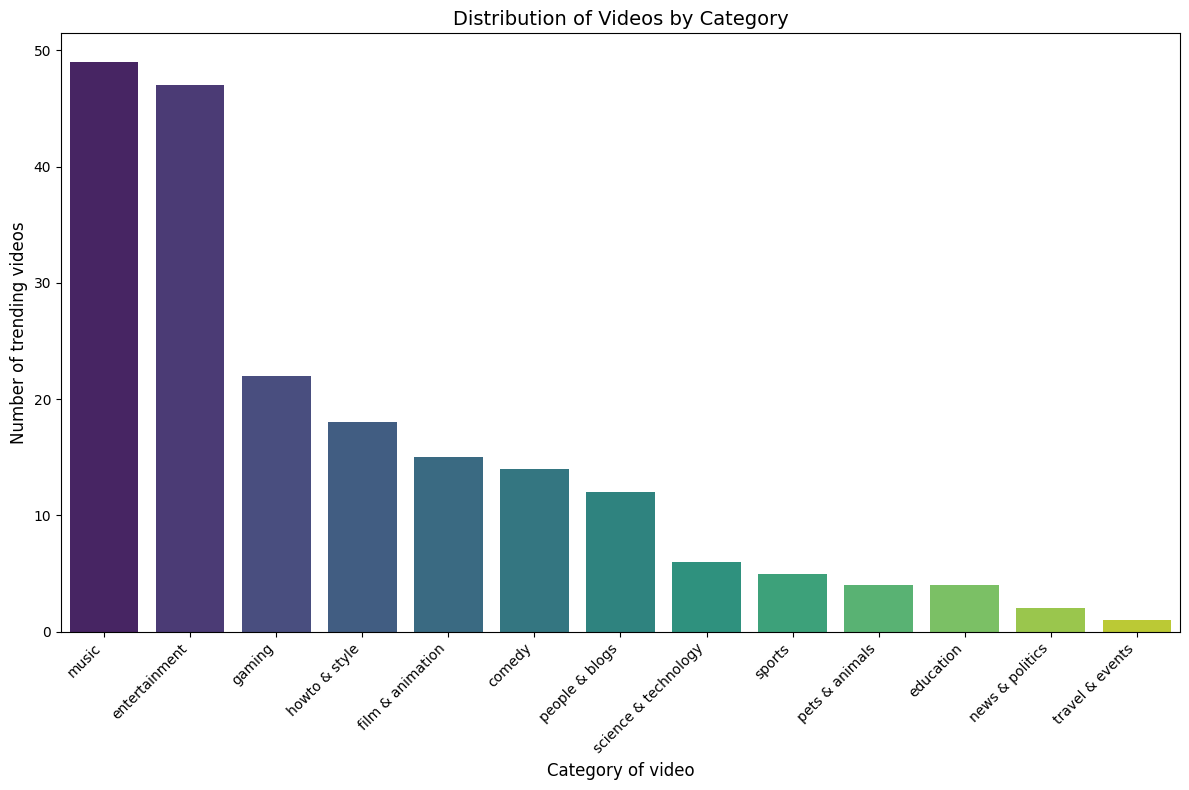

In [59]:
latest_data = df[df['trending_date'] == df['trending_date'].max()]

# Count the number of videos in each category
category_counts = latest_data['cat_title'].value_counts()

# Create a bar plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set labels and title
plt.xlabel('Category of video', fontsize=12)
plt.ylabel('Number of trending videos', fontsize=12)
plt.title('Distribution of Videos by Category', fontsize=14)

# Adjust plot layout to prevent x-axis labels from overlapping
plt.tight_layout()

# Display the plot
plt.show()


### Trend Analysis

In [60]:
# selecting a particular video to perform analysis
vid_id = df['video_id'][0]
vid_df = df[df['video_id']==vid_id]
video_title = vid_df['vid_title'].unique()[0]


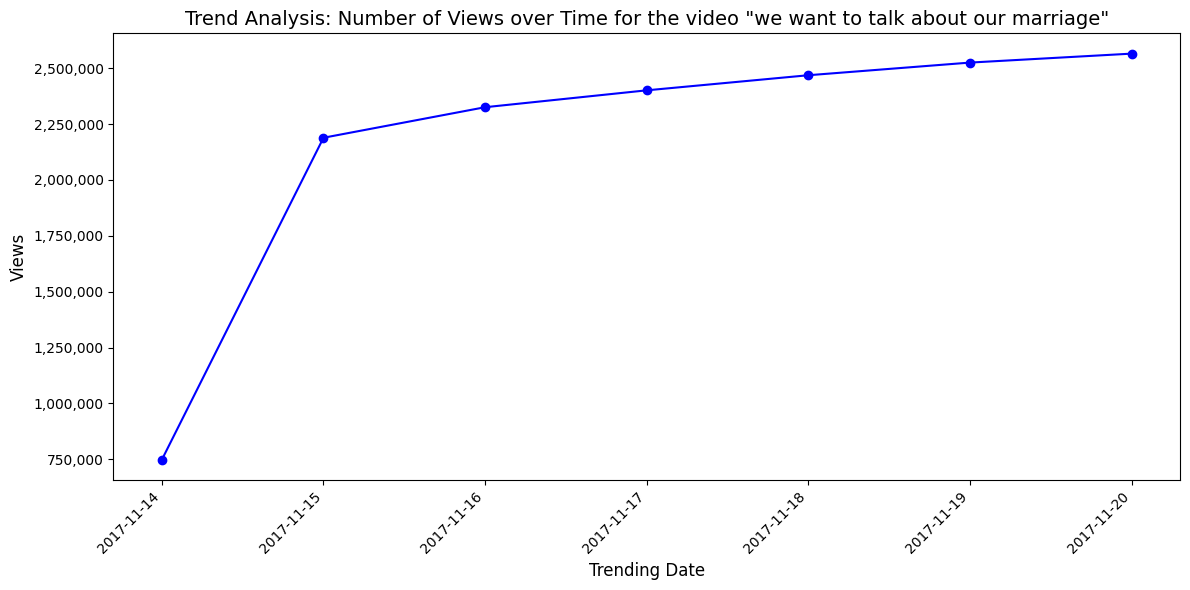

In [61]:
# Group the data by trending date and calculate the sum of views, likes, dislikes, or comment count
trend_data = vid_df.groupby('trending_date')['views'].sum()  # Replace 'views' with the desired column

# Create a line chart
plt.figure(figsize=(12, 6))
plt.plot(trend_data.index, trend_data.values, marker='o', linestyle='-', color='blue')

# Set labels and title
plt.xlabel('Trending Date', fontsize=12)
plt.ylabel('Views', fontsize=12)
plt.title(f'Trend Analysis: Number of Views over Time for the video \"{video_title}\"', fontsize=14)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format as comma-separated integers

# Display the plot
plt.tight_layout()
plt.show()


In [62]:
# df = df.sample(frac=0.1)

## Feature Engineering

In [65]:
# Extract useful information from publish_time
df['publish_day_of_week'] = df['publish_time'].dt.dayofweek
df['publish_hour_of_day'] = df['publish_time'].dt.hour

# Convert catergory_id to int
df['category_id'] = df['category_id'].astype(int)


In [67]:

# Perform text preprocessing on video title and description
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Remove punctuation, convert to lowercase, and split into words
    words = nltk.word_tokenize(text.lower())
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    # Perform stemming/lemmatization
    words = [stemmer.stem(word) for word in words]
    # Join the words back into a string
    preprocessed_text = ' '.join(words)
    return preprocessed_text

df['vid_title_preprocessed'] = df['vid_title'].apply(preprocess_text)
df['description_preprocessed'] = df['description'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bpathak10/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Save the data ready to train

In [68]:
df.to_csv("train_data.csv",index=False)

### Upload the processed csv file to azure

In [ ]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient

connect_str = ""
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

container_name = "azureml"
blob_client = blob_service_client.get_blob_client(container=container_name, blob="cleaned_data")

with open("train_data.csv", "rb") as data:
    await blob_client.upload_blob(data)

### Data split

In [69]:
# Split the dataset into training and testing sets
X_text = df[['vid_title_preprocessed', 'description_preprocessed']]
X_numeric = df[['publish_day_of_week','publish_hour_of_day','likes','dislikes','comment_count','category_id']] 
y = df['views'] 

X_text_train, X_text_test, X_numeric_train, X_numeric_test, y_train, y_test = train_test_split(X_text, X_numeric, y, test_size=0.2, random_state=42)

# Apply CountVectorizer on text features
count_vectorizer = CountVectorizer()
title_bow_train = count_vectorizer.fit_transform(X_text_train['vid_title_preprocessed'])
description_bow_train = count_vectorizer.transform(X_text_train['description_preprocessed'])

title_bow_test = count_vectorizer.transform(X_text_test['vid_title_preprocessed'])
description_bow_test = count_vectorizer.transform(X_text_test['description_preprocessed'])

# Apply TfidfVectorizer on text features
tfidf_vectorizer = TfidfVectorizer()
title_tfidf_train = tfidf_vectorizer.fit_transform(X_text_train['vid_title_preprocessed'])
description_tfidf_train = tfidf_vectorizer.transform(X_text_train['description_preprocessed'])

title_tfidf_test = tfidf_vectorizer.transform(X_text_test['vid_title_preprocessed'])
description_tfidf_test = tfidf_vectorizer.transform(X_text_test['description_preprocessed'])


## Model selection

In [70]:
# Concatenate the numeric features with the text features
X_train = scipy.sparse.hstack((title_bow_train, description_bow_train, title_tfidf_train, description_tfidf_train, X_numeric_train))
X_test = scipy.sparse.hstack((title_bow_test, description_bow_test, title_tfidf_test, description_tfidf_test, X_numeric_test))

# Select a predictive model
model = RandomForestRegressor(verbose=1)

## Model Training

In [71]:
# Train the predictive model
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 72.0min finished


RandomForestRegressor(verbose=1)

## Model Evaluation

In [72]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Squared Error: 670511793157.8562
Mean Absolute Error: 193341.1757366865
R-squared: 0.9900221975027258


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


# Model Prediction

In [87]:
# Assuming new_publish_time_hour and new_publish_time_week are lists
new_title = ['The perks of learning']
new_description = ['Learning is an art which is an endless process']
new_publish_time_hour = 20
new_publish_time_week = 6
likes = 1256783
dislikes = 4378
comments_count = 235
category_id = 15

new_title_bow = count_vectorizer.transform(new_title)
new_description_bow = count_vectorizer.transform(new_description)
new_title_tfidf = tfidf_vectorizer.transform(new_title)
new_description_tfidf = tfidf_vectorizer.transform(new_description)

# Create the new_numeric DataFrame
new_numeric = pd.DataFrame({ 'publish_day_of_week':new_publish_time_week,'publish_hour_of_day':new_publish_time_hour,
    'likes':likes,'dislikes':dislikes,'comment_count':comments_count,'category_id':category_id},index=[0])

# Concatenate the sparse matrices and numeric DataFrame
new_data = hstack((new_title_bow, new_description_bow, new_title_tfidf, new_description_tfidf, new_numeric.values))

new_predictions = model.predict(new_data)
print("The Predicted views based on the given data is :", int(new_predictions[0]))

The Predicted views based on the given data is : 14194239


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### Save the trained model

In [74]:
import pickle

# Assuming you have a trained model called 'model'
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)


# Azure ML training

## Connecting to  the workspace

In [75]:
import azureml.core
from azureml.core import Workspace, Experiment
from azureml.core import Environment, ScriptRunConfig

In [76]:
# read the credentials from the config.json
with open('config.json') as f:
    cred = json.load(f)

In [ ]:
# Define your Azure ML workspace
workspace = Workspace.get(name=cred['workspace_name'], subscription_id=cred['subscription_id'], resource_group=cred['resource_group'])

# Create a new experiment
experiment_name = 'random-forest-training'
experiment = Experiment(workspace, experiment_name)

# Define the training script
script_path = 'train.py'

# Create a Python environment for the script dependencies
environment = Environment('my-env')
environment.python.user_managed_dependencies = True

# Create a script run configuration
run_config = ScriptRunConfig(
    source_directory='youtube-views',
    script=script_path,
    compute_target='ml-studio-compute',
    environment=environment
)

# Submit the training experiment
run = experiment.submit(run_config)

print('Training experiment submitted successfully.')

# Monitor the run's progress
run.wait_for_completion(show_output=True)  # This will display the logs and progress

# Get the run details
run_details = run.get_details()

# Access run properties
run_properties = run.get_properties()

# Access run metrics
run_metrics = run.get_metrics()